In [1]:
import krpc
import pandas as pd
import time
import seaborn as sns
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle

%matplotlib inline

In [2]:
def open_connection():
    return krpc.connect(
    name='My Hover Program',
    address='127.0.0.1')

In [3]:
# situation operator functions 
def is_flying(vessel):
    return vessel.situation == vessel.situation.flying

def is_landed(vessel):
    return vessel.situation == vessel.situation.landed


def gravity_estimate(body_mass, radius, altitude):
    return 6.67430e-11 * (body_mass / pow((radius + altitude),2))

def continue_holding_pattern(powered_flight,elapsed_time, seconds):
    return powered_flight and elapsed_time < seconds

#  flight information
def elapsed_time(start,end):
    return (end - start)

def ship_elements(vessel):
    flight_info = vessel.flight()
    orbit_info = vessel.orbit
    craft_altitude = conn.add_stream(getattr,flight_info,'surface_altitude')
    refframe = vessel.orbit.body.reference_frame
    position = conn.add_stream(vessel.position, refframe)
    mean_altitude = conn.add_stream(getattr,flight_info,'mean_altitude')
    max_thrust = conn.add_stream(getattr,vessel,'max_thrust')
    vertical_speed =conn.add_stream(getattr,vessel.flight(refframe),'vertical_speed')
    current_mass = conn.add_stream(getattr,vessel,'mass')
    return flight_info, craft_altitude, refframe, position, mean_altitude, current_mass, max_thrust, vertical_speed, orbit_info

In [4]:
def set_thrust(vessel,thrust_to_weight, weight, max_thrust):
    throttle_setting = ( (thrust_to_weight if thrust_to_weight >= 0 else 0) * weight) / max_thrust
    vessel.control.throttle = throttle_setting
    return throttle_setting

def determine_thrust_to_weight(vessel,vertical_speed, thrust_to_weight):
    if vertical_speed > 0: # then I'm rising and need to slow
        thrust_to_weight_option = thrust_to_weight - vertical_speed**(1/3)
        thrust_to_weight = thrust_to_weight_option if thrust_to_weight_option >= 0 else 0
    if vertical_speed < 0: # then I'm falling and need to thrust
        thrust_to_weight = thrust_to_weight + pow(abs(vertical_speed),(8**-1))
    return thrust_to_weight

In [5]:
def hover(conn, seconds = 1000, thrust_to_weight = 1):
    df = pd.DataFrame({'timestamp':pd.Series([], dtype='str'),
            'altitude': pd.Series([], dtype='str'),
            'vertical_velocity': pd.Series([], dtype='str'),
            'weight': pd.Series([], dtype='str'),
            'thrust': pd.Series([], dtype='str'),
            'thurst-to-weight': pd.Series([], dtype='str'),
            'throttle_setting': pd.Series([], dtype='str'),})
    vessel = conn.space_center.active_vessel
    flight_info, craft_altitude, refframe, position, mean_altitude, current_mass, max_thrust, vertical_speed, orbit_info = ship_elements(vessel)
    start = time.time()
    while continue_holding_pattern(is_flying(vessel),elapsed_time(start,time.time()), seconds):
        gravity_est = gravity_estimate(5.2915158e22,600000,mean_altitude())
        weight = current_mass() * gravity_est
        thrust_to_weight = determine_thrust_to_weight(vessel,vertical_speed(), thrust_to_weight)
        throttle = set_thrust(vessel,thrust_to_weight, weight, max_thrust())
        vessel.control.throttle = throttle
        dict = {'timestamp':round(time.time()),
            'altitude':craft_altitude(),
                'velocity':vertical_speed(),
                'weight':weight,
                'thrust':(max_thrust() * throttle),
                'thurst-to-weight': thrust_to_weight,
                'throttle_setting':throttle, 
                'gravitational_pull': gravity_est}
        df = df.append(dict, ignore_index = True)
        time.sleep(.1)
        clear_output(wait=True)
        display('{} seconds remaining'.format(round(seconds - (time.time() - start))))
    vessel.control.throttle = 0
    return df

In [42]:
def burn_height(initial_velocity, acceleration, current_mass):
    return abs(-((initial_velocity**2)/(2*(acceleration))))



def experiemental_burn_height(gravity, apoapsis, acceleration):
    return (gravity * apoapsis) / (acceleration + gravity)

atm_model = np.loadtxt('kerbin_atmosphere.txt')
altx = atm_model[:,0]
deny = atm_model[:,3]

def atmosphere_model(altitude):
    global altx,deny
    return np.interp(altitude, altx, deny)


def air_resistance(altitude, mass, velocity_z):
    if altitude < 0:
        rho = 1.0
    else:
        rho = atmosphere_model(altitude)
        
        
    S = 0.01
    Cd = 0.1
    
    qinf = -np.pi * rho * S * Cd/mass
    return qinf * abs(velocity_z)* velocity_z


def acceleration(thrust, mass ,gravity, air_resistance):
    return (thrust / mass) - (gravity + air_resistance)

def burn_time(initial_velocity, thurst, current_mass):
    if initial_velocity > 0: # means I'm not falling yet
        return 0
    return abs(initial_velocity) / (thurst/current_mass) # velocity will be negative

def calcualte_time_to_impact(altitude, velocity):
    if velocity > 0:
        return 3600
    return altitude / abs(velocity)

In [43]:
def landing_option_one(gravity_est,weight, velocity):
    if velocity <= -15:
        throttle = 0.75
        clear_output(wait=True)
        display('''Velocity {} m/s | below -15m/s throttle to {}%'''.format(round(vertical_speed()),throttle))
    if velocity < - 5 and vertical_speed() > -10:
        pct = 0.75
        throttle = throttle * pct
        clear_output(wait=True)
        display('''Velocity {} m/s | between -15 and -7 m/s throttle to {}% of current'''.format(round(vertical_speed()), pct))
    if velocity >= -5 and vertical_speed() <=0 : # safe landing speed
        throttle = throttle * math.sqrt(throttle)
        clear_output(wait=True)
        display('''Velocity {} m/s | below -7 m/s maintaining thrust'''.format(round(vertical_speed())))
    if velocity > 0: #  i have accelerated too much and am now climbing
        pct = 0.5
        throttle = throttle * pct
        clear_output(wait=True)
        display('''Velocity {} m/s | greater than 0 m/s throttle to {}% of current'''.format(round(vertical_speed()), pct))
    return throttle


def landing_option_two(mass, gravity, altitude, velocity, thrust_max):
    clear_output(wait=True)
    display('''Mass {} | gravity {} |altitude {} |velocity {} | thrust {}'''.format(round(mass), gravity, round(altitude), round(velocity), round(thrust_max)))
    if altitude > 300:
        delta_v = -200 - velocity
        msg = 'greater than 300'
    if altitude > 200 and altitude < 300:
        delta_v = -100 - velocity
        msg = 'greater than 200'
    if altitude > 50 and altitude <= 200:
        delta_v = -25 - velocity
        msg = 'greater than 75'
    if altitude <= 30:
        delta_v = -7 - velocity
        msg = 'below than 75'
    delta_v_per_second = delta_v / 0.05
    dvs_times_mass = delta_v_per_second * mass
    dvsm_plus_gravity = dvs_times_mass + gravity
    pct_of_thrust = (dvsm_plus_gravity / thrust_max) * 100
    display('''Altitude {} throttle to {}% of current'''.format(msg,round(pct_of_thrust)))
    return pct_of_thrust

def isRadarBelowStoppingDistance(radar, stopping_distance):
    return radar < stopping_distance

def stoppingDistance(velocity, max_deceleration):
    return (velocity**2)/(2*max_deceleration)

def idealThrottle(stopping_distance, radar):
    return stopping_distance / radar

def landing_option_three(velocity, max_deceleration, radar, decelerating = False):
    throttle = 0
    clear_output(wait=True)
    display('''Velocity {} | Decel {} | Radar {} '''.format(round(velocity,2), round(max_deceleration,2), round(radar,2)))
    stopDist = stoppingDistance(velocity, max_deceleration)
    if velocity < -700 and not isRadarBelowStoppingDistance(radar, stopDist) and not decelerating:
        throttle = 1
        decelerating = True
        display('''Entry Burn''')
    if velocity > -310 and not isRadarBelowStoppingDistance(radar, stopDist):
        throttle = 0
        display('''Pause''')
    if isRadarBelowStoppingDistance(radar, stopDist):
        throttle = idealThrottle(stopDist, radar)
        display('''Deceleration Burn => {}'''.format(round(throttle, 3)))
    if velocity > -0.1 and isRadarBelowStoppingDistance(radar, stopDist):
        throttle = 0
        display('''Engine Stop''')
    return throttle, decelerating

In [86]:
def land(conn):
    burn_position = 0
    intiated_position = None
    vessel = conn.space_center.active_vessel
    flight_info, craft_altitude, refframe, position, mean_altitude, current_mass, max_thrust, vertical_speed, orbit_info = ship_elements(vessel)
    start = time.time()
    decelerating = False
    while vertical_speed() > 0: # if craft is still flying upward, wait to start the landing sequence 
        clear_output(wait=True)
        display('Craft is Still in Upward Flight: {} m/s'.format(round(vertical_speed())))
    while vertical_speed() < 0: #  i am past my apoapsis and am falling
        gravity_calculation = gravity_estimate(5.2915158e22,600000,mean_altitude())
        ar = air_resistance(craft_altitude(),current_mass(),vertical_speed() )
        a = acceleration(max_thrust(), current_mass(),gravity_calculation, ar)
#         burn_start = burn_height(vertical_speed(), a, current_mass())
#         burn_start = experiemental_burn_height(9.81,orbit_info.apoapsis - 600000, a)
#         if burn_position == 0:
#             burn_position = burn_start
#         burn = burn_time(vertical_speed(), a, current_mass())
#         time_to_impact = calcualte_time_to_impact(craft_altitude(),vertical_speed())
#         if (craft_altitude()) <= burn_position and is_flying(vessel):
#             throttle = 1
#             vessel.control.throttle = throttle
#             a = acceleration(max_thrust(), current_mass(),gravity_calculation, ar)
#             pause = abs(round(vertical_speed()) / round(a))
#             display('''Waiting: {}'''.format(pause))
#             while vertical_speed() < -40:
#                 pass
        throttle = 0
        while not is_landed(vessel):
            heightOfCoM = 7
            gravity_est = gravity_estimate(5.2915158e22,600000,mean_altitude())
            radar = craft_altitude() - heightOfCoM
            max_decel = (max_thrust() / current_mass()) - gravity_est
#                 weight = current_mass() * gravity_est
            a = acceleration(max_thrust() * throttle, current_mass(),gravity_calculation, ar)
#                 vessel.control.throttle = landing_option_one(gravity_est,weight,vertical_speed())
#                 throttle = landing_option_two(current_mass(), gravity_est, craft_altitude(), vertical_speed(), max_thrust())
            throttle, decelerating =  landing_option_three(vertical_speed(), max_decel, radar, decelerating)
            vessel.control.throttle = throttle
#                 time.sleep(.05)
        vessel.control.throttle = 0
        break;
        if is_landed(vessel) or not is_flying(vessel):
            vessel.control.throttle = 0
            break;
        clear_output(wait=True)
        display('''Burn Height: {} m | Acceleration: {} m/s**2 | Velocity {} m/s'''.format(round(burn_position),round(a), round(vertical_speed())))
    vessel.control.throttle = 0
    print('''Test Information
----------------
Radar {}
Mean Altitude'''.format(radar, mean_altitude))
    # calculate a
    # determine dist (add 1 m)
    # check current altitude
        # if current = dist, set thrust to 1         
    
    



In [87]:
# conn = open_connection()
conn.close()

In [88]:
conn = open_connection()
#  test = hover(conn, 5,0.99)
time.sleep(2)
land(conn)
conn.close()

'Velocity -286.56 | Decel -9.78 | Radar -7.37 '

'Pause'

ZeroDivisionError: float division by zero

In [ ]:
def position_eq(velocity_i, altitude, time_in_seconds, g):
    return (-g/2)*(time_in_seconds**2) + velocity_i*time_in_seconds + altitude  
    
def velocity_eq(time_in_seconds, velocity_i,g ):
    return (-g * time_in_seconds) + velocity_i

In [35]:
def position_test(conn):
    df = pd.DataFrame({'timestamp':pd.Series([], dtype='str'),
            'altitude': pd.Series([], dtype='str'),
            'vertical_velocity': pd.Series([], dtype='str'),
            'est_position': pd.Series([], dtype='str'),
            'est_velocity': pd.Series([], dtype='str'),
                      })
    vessel = conn.space_center.active_vessel
    flight_info, craft_altitude, refframe, position, mean_altitude, current_mass, max_thrust, vertical_speed = ship_elements(vessel)
    start = time.time()
    initial_speed = vertical_speed()
    initial_alt = craft_altitude()
    while is_flying(vessel):
        time_e = elapsed_time(start,time.time())
        est_position = position_eq(initial_speed,initial_alt,time_e, gravity_est = gravity_estimate(5.2915158e22,600000,mean_altitude()))
        est_velocity = velocity_eq(time_e, initial_speed)
        dict = {'timestamp':round(time.time()),
                'altitude':craft_altitude(),
                'vertical_velocity':vertical_speed(),
                'est_position':est_position,
                'est_velocity':est_velocity,}
        df = df.append(dict, ignore_index = True)
        clear_output(wait=True)
    return df

In [37]:
conn = open_connection()
results = position_test(conn)
conn.close()

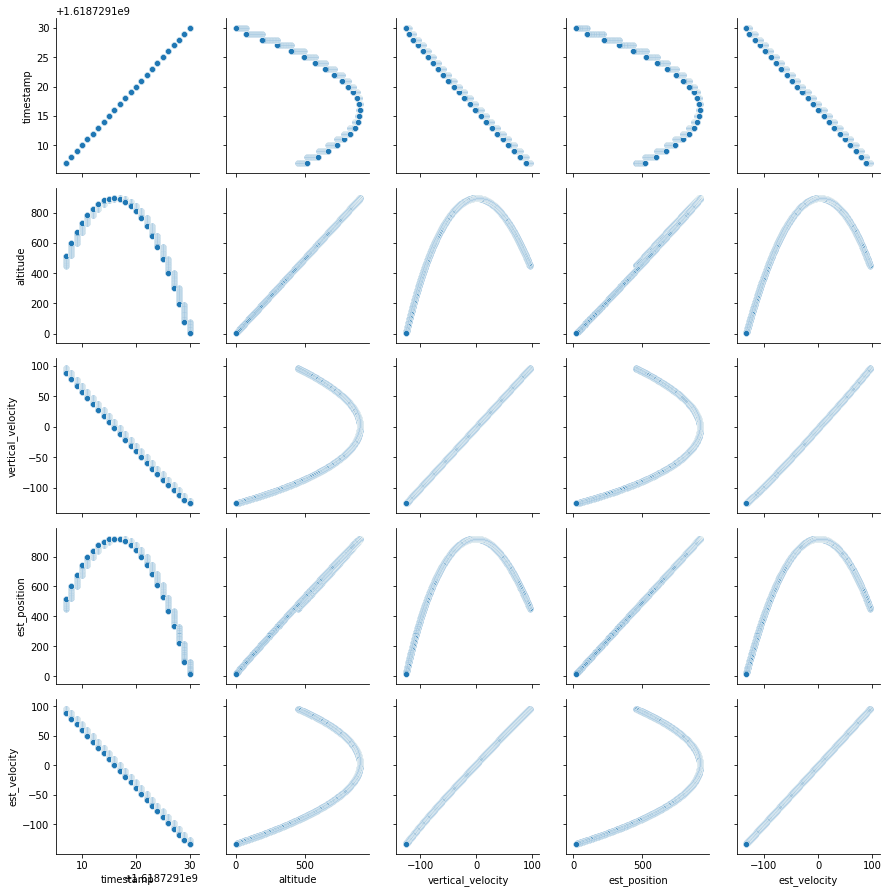

In [22]:
# plots = [sns.scatterplot(data=test, x="timestamp", y=x) for x in test.columns]
# plots
g = sns.PairGrid(results)
g.map(sns.scatterplot)

In [23]:
results['v_dif'] = (results['vertical_velocity'] - results['est_velocity'])/ results['est_velocity']
results['p_dif'] = (results['altitude'] - results['est_position']) / results['est_position']

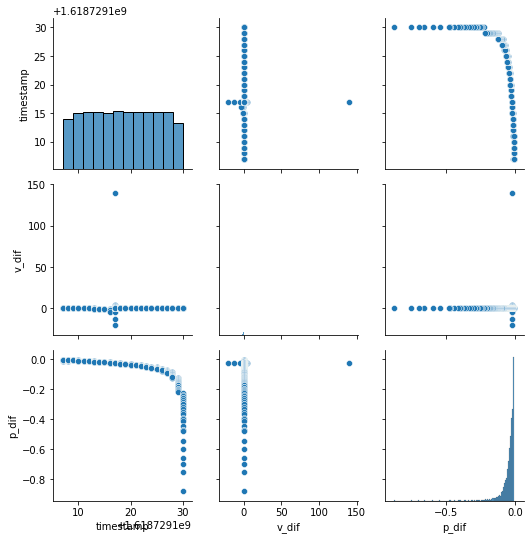

In [24]:
g = sns.PairGrid(results[['timestamp','v_dif','p_dif']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)


In [25]:
results.loc[100:105]

,timestamp,altitude,vertical_velocity,est_position,est_velocity,v_dif,p_dif
100,1.618729e+09,619.520617,74.745625,624.451673,76.110205,-0.017929,-0.007897
101,1.618729e+09,621.014086,74.538620,625.843524,75.930794,-0.018335,-0.007717
102,1.618729e+09,622.483141,74.331684,628.214769,75.624123,-0.017090,-0.009124
103,1.618729e+09,623.971606,74.124818,629.418214,75.468019,-0.017798,-0.008653
104,1.618729e+09,625.465075,73.918020,630.808951,75.287209,-0.018186,-0.008471
105,1.618729e+09,626.934130,73.711292,631.979371,75.134692,-0.018945,-0.007983


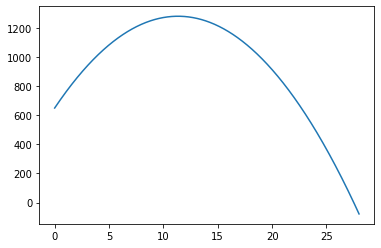

In [230]:

# create 1000 equally spaced points between -10 and 10
x = np.linspace(0, 28, 1000)

# calculate the y value for each element of the x vector
y = -4.9*(x**2) + 111.2*x + 650  

fig, ax = plt.subplots()
ax.plot(x, y)

In [192]:
conn.close()

In [190]:
conn = open_connection()
vessel = conn.space_center.active_vessel
vessel.parts.sensors[1].value

'308.56  K'

In [194]:
#  save information
def collect_atm_data():
    df = pd.DataFrame({'timestamp':pd.Series([], dtype='str'),
        'altitude': pd.Series([], dtype='str'),
        'barometer': pd.Series([], dtype='str'),
        'temp': pd.Series([], dtype='str'),
                  })
    vessel = conn.space_center.active_vessel
    barometer = conn.add_stream(getattr,vessel.parts.sensors[0],'value')
    thermometer = conn.add_stream(getattr,vessel.parts.sensors[1],'value')
    flight_info, craft_altitude, refframe, position, mean_altitude, current_mass, max_thrust, vertical_speed = ship_elements(vessel)
    start = time.time()
    initial_speed = vertical_speed()
    initial_alt = craft_altitude()
    while craft_altitude() > 10:
        time_e = elapsed_time(start,time.time())
        est_position = position_eq(initial_speed,initial_alt,time_e, gravity_estimate(5.2915158e22,600000,mean_altitude()))
        if craft_altitude() % 50:
            dict = {'timestamp':round(time.time()),
                    'altitude':craft_altitude(),
                    'calculated_position': est_position,
                    'barometer':barometer(),
                   'temp': thermometer()}
            df = df.append(dict, ignore_index = True)
    return df


In [195]:
conn = open_connection()
atm_data = collect_atm_data()
conn.close()

In [205]:
atm_data = atm_data[atm_data.barometer !='MINIMAL']
atm_data['pressure'] = atm_data['barometer'].map(lambda x: float(x.rstrip(' kPa')) * 1000)
atm_data['tempurature'] = atm_data['temp'].map(lambda x: float(x.rstrip(' K')))
atm_data.head()

,timestamp,altitude,barometer,temp,calculated_position,pressure,tempurature
1537,1618779021,68151.084817,0.0001 kPa,319.83 K,68175.261520,0.1,319.83
1538,1618779021,68151.084817,0.0001 kPa,319.83 K,68172.925089,0.1,319.83
1539,1618779021,68151.084817,0.0001 kPa,319.83 K,68170.306674,0.1,319.83
1540,1618779021,68144.048485,0.0001 kPa,319.83 K,68167.245068,0.1,319.83
1541,1618779021,68144.048485,0.0001 kPa,319.83 K,68164.882333,0.1,319.83


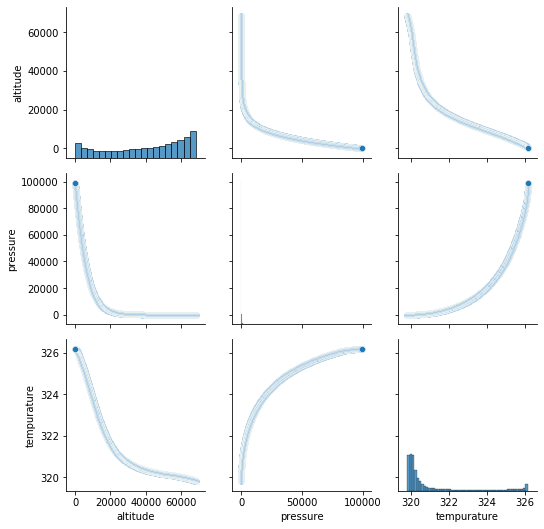

In [206]:
g = sns.PairGrid(atm_data[['altitude','pressure','tempurature']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)


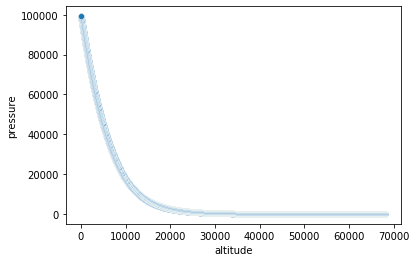

In [209]:
sns.scatterplot(data= atm_data, x = 'altitude', y = 'pressure')

In [218]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = atm_data[['altitude']]
y = atm_data['pressure']
reg = LinearRegression().fit(X, y)

In [221]:
reg.predict(np.array([[1]]))

array([36576.77008986])

/Users/milo1226/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


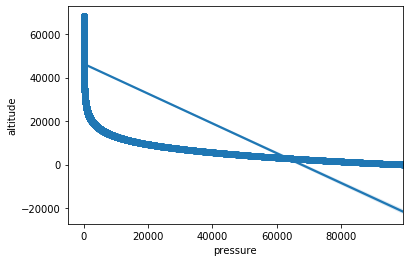

In [222]:
sns.regplot(atm_data['pressure'],atm_data['altitude'])

In [ ]:
reg.score(X, y)
reg.coef_
array([1., 2.])
reg.intercept_
reg.predict(np.array([[3, 5]]))

In [247]:
def steady_flight(conn):
    vessel = conn.space_center.active_vessel
    flight_info, craft_altitude, refframe, position, mean_altitude, current_mass, max_thrust, vertical_speed = ship_elements(vessel)
    heading = conn.add_stream(getattr,flight_info,'heading')
    pitch = conn.add_stream(getattr,flight_info,'pitch')
#     autopilot = vessel.auto_pilot
#     autopilot.engage()
    while True:
        clear_output(wait=True)
        display('''Heading: {}  | Pitch: {} '''.format(heading(), pitch()))
#         autopilot.target_pitch = 0
#         autopilot.target_pitch_and_heading(0,90)

In [248]:
conn = open_connection()
steady_flight(conn)

'Heading: 291.494873046875  | Pitch: 16.1851806640625 '

KeyboardInterrupt: 

In [249]:
conn.close()

In [250]:
atm_data.to_csv('atm_data.csv')

In [5]:
atm_data = pd.read_csv('atm_data.csv')
atm_data.columns

Index(['Unnamed: 0', 'timestamp', 'altitude', 'barometer', 'temp',
       'calculated_position', 'pressure', 'tempurature'],
      dtype='object')

In [6]:
atm_data[atm_data['altitude'] > 2000]

,Unnamed: 0,timestamp,altitude,barometer,temp,calculated_position,pressure,tempurature
0,1537,1618779021,68151.084817,0.0001 kPa,319.83 K,68175.261520,0.1,319.83
1,1538,1618779021,68151.084817,0.0001 kPa,319.83 K,68172.925089,0.1,319.83
2,1539,1618779021,68151.084817,0.0001 kPa,319.83 K,68170.306674,0.1,319.83
3,1540,1618779021,68144.048485,0.0001 kPa,319.83 K,68167.245068,0.1,319.83
4,1541,1618779021,68144.048485,0.0001 kPa,319.83 K,68164.882333,0.1,319.83
5,1542,1618779021,68144.048485,0.0001 kPa,319.83 K,68162.325876,0.1,319.83
6,1543,1618779021,68137.008632,0.0001 kPa,319.83 K,68159.593187,0.1,319.83
7,1544,1618779021,68137.008632,0.0001 kPa,319.83 K,68156.810847,0.1,319.83
8,1545,1618779021,68137.008632,0.0001 kPa,319.83 K,68154.250622,0.1,319.83
9,1546,1618779021,68129.968770,0.0001 kPa,319.83 K,68151.429611,0.1,319.83


In [73]:
df = pd.DataFrame({'timestamp':pd.Series([], dtype='str'),
            'est_position': pd.Series([], dtype='str'),
            'est_velocity': pd.Series([], dtype='str'),
                      })

initial_speed = 0
initial_alt = 1250
mean_altitude = 1250
for t in  range(20):
    time_e = t
    est_position = position_eq(initial_speed,initial_alt,time_e,gravity_estimate(5.2915158e22,600000,mean_altitude))
    est_velocity = velocity_eq(time_e, initial_speed, gravity_estimate(5.2915158e22,600000,mean_altitude))
    dict = {'timestamp':t,
            'est_position':est_position,
            'est_velocity':est_velocity,}
    df = df.append(dict, ignore_index = True)
    mean_altitude = est_position

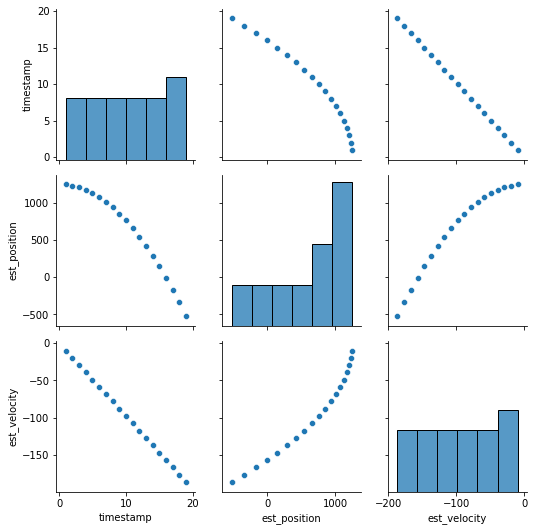

In [74]:
g = sns.PairGrid(df[df['est_velocity'] < 0])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

In [75]:
df['distance'] = df['est_velocity'].apply(lambda x: x**2 / (2*11.19))
df[(df['est_position'] > df['distance']) & (df['est_velocity'] < 0)]

,timestamp,est_position,est_velocity,distance
1,1.0,1245.115213,-9.769574,4.264727
2,2.0,1230.460534,-19.539466,17.059461
3,3.0,1206.034058,-29.310628,38.387530
4,4.0,1171.831974,-39.084013,68.255589
5,5.0,1127.848561,-48.860576,106.673630
6,6.0,1074.076187,-58.641271,153.654990
7,7.0,1010.505298,-68.427058,209.216364
8,8.0,937.124416,-78.218896,273.377823
9,9.0,853.920126,-88.017750,346.162836
10,10.0,760.877065,-97.824587,427.598294


In [76]:
df_melted = df[['timestamp','est_position','distance']].melt('timestamp', var_name='Position&Distance',  value_name='Meters')
df_melted

,timestamp,Position&Distance,Meters
0,0.0,est_position,1250.000000
1,1.0,est_position,1245.115213
2,2.0,est_position,1230.460534
3,3.0,est_position,1206.034058
4,4.0,est_position,1171.831974
5,5.0,est_position,1127.848561
6,6.0,est_position,1074.076187
7,7.0,est_position,1010.505298
8,8.0,est_position,937.124416
9,9.0,est_position,853.920126


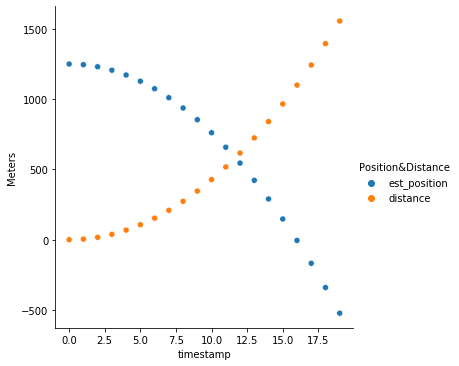

In [77]:
sns.relplot(data=df_melted,x='timestamp',y='Meters',hue='Position&Distance')

In [90]:
conn.close()

In [89]:
def takeoff(conn, altitude):
    speed_min = 100
    speed_step = 50
    pitch_max = 90
    pitch_min = 10
    pitch_step = 5
    
    vessel = conn.space_center.active_vessel
    flight_info, craft_altitude, refframe, position, mean_altitude, current_mass, max_thrust, vertical_speed, orbit_info = ship_elements(vessel)
    start = time.time()
    autopilot = vessel.auto_pilot
    autopilot.engage()
    autopilot.target_pitch_and_heading(90, 0)
    vessel.control.throttle = 1
    vessel.control.activate_next_stage() # release clamps and start engine
    while craft_altitude() < 100000:
        if craft_altitude() < 45000:
            if vertical_speed() >= 1500:
                vessel.control.throttle = 0.5
            if craft_altitude() >= 20000:
                autopilot.target_pitch_and_heading(75, 90)
        if craft_altitude() < 60000 and craft_altitude() >= 45000:
            if vertical_speed() >= 2000:
                vessel.control.throttle = 0.75
            if craft_altitude() < 40000:
                autopilot.target_pitch_and_heading(30, 90)
        if craft_altitude() >= 60000 and vessel.orbit.apoapsis_altitude < 80000:
            vessel.control.throttle = 1
        if craft_altitude() > 65000:
            autopilot.target_pitch_and_heading(0, 90)
        if vessel.orbit.apoapsis_altitude >= altitude:
            vessel.control.throttle = 0
            break
        clear_output(wait=True)
        display('''Altitude: {} m | Apoapsis: {} m | Periapsis {} m'''.format(round(craft_altitude()),round(vessel.orbit.apoapsis_altitude), round(vessel.orbit.periapsis_altitude)))
    vessel.control.throttle = 0
    while vessel.orbit.time_to_apoapsis > 10:
        clear_output(wait=True)
        display('''Coasting... Altitude: {} m | Apoapsis: {} m | Periapsis {} m'''.format(round(craft_altitude()),round(vessel.orbit.apoapsis_altitude), round(vessel.orbit.periapsis_altitude)))
    while vessel.orbit.periapsis_altitude < altitude:
        autopilot.target_pitch_and_heading(0, 90)
        vessel.control.throttle = 1
        clear_output(wait=True)
        display('''Circularizing... Altitude: {} m | Apoapsis: {} m | Periapsis {} m'''.format(round(craft_altitude()),round(vessel.orbit.apoapsis_altitude), round(vessel.orbit.periapsis_altitude)))
        if vessel.orbit.periapsis_altitude >= altitude:
            vessel.control.throttle = 0
            break
    
    
    

In [85]:
conn = open_connection()
takeoff(conn,90000)
conn.close()

'Altitude: 38334 m | Apoapsis: 89955 m | Periapsis -594399 m'

In [78]:
vi = -100
v = vi
height = 10000 #meters
gravity = -9.81 #meters per squared seconds

In [79]:
time_to_impact = math.sqrt((2 * height)/ - gravity)
print('Impact time: {} seconds'.format(round(time_to_impact)))

Impact time: 45 seconds


In [80]:
for second in range(36):
    v = vi + gravity * (second + 1)
    distance = (vi * (1 + second)) + (.5 * gravity * (second + 1)**2)
    print('time: {} seconds | height: {} | velocity {}'.format(second, height + distance, round(v,3)))

time: 0 seconds | height: 9895.095 | velocity -109.81
time: 1 seconds | height: 9780.38 | velocity -119.62
time: 2 seconds | height: 9655.855 | velocity -129.43
time: 3 seconds | height: 9521.52 | velocity -139.24
time: 4 seconds | height: 9377.375 | velocity -149.05
time: 5 seconds | height: 9223.42 | velocity -158.86
time: 6 seconds | height: 9059.655 | velocity -168.67
time: 7 seconds | height: 8886.08 | velocity -178.48
time: 8 seconds | height: 8702.695 | velocity -188.29
time: 9 seconds | height: 8509.5 | velocity -198.1
time: 10 seconds | height: 8306.494999999999 | velocity -207.91
time: 11 seconds | height: 8093.68 | velocity -217.72
time: 12 seconds | height: 7871.055 | velocity -227.53
time: 13 seconds | height: 7638.62 | velocity -237.34
time: 14 seconds | height: 7396.375 | velocity -247.15
time: 15 seconds | height: 7144.32 | velocity -256.96
time: 16 seconds | height: 6882.455 | velocity -266.77
time: 17 seconds | height: 6610.78 | velocity -276.58
time: 18 seconds | hei

In [2]:
a = -9.81 * .5 #gravity
b = -100 # inital velocity
c = 10000

pos_x = (-b + math.sqrt(b**2 - 4*a*c))/ (2 * a) 
neg_x = (-b - math.sqrt(b**2 - 4*a*c))/ (2 * a) 
print('{} | {}'.format(pos_x, neg_x))

-56.48241606419054 | 36.09505622728941


In [3]:
round(neg_x)

36

In [35]:
with open('/Users/milo1226/Desktop/7_python_projects/KerbalSpaceProgram/flightInfo.pkl', 'rb') as f:
    flight_info = pickle.load(f)

In [42]:
with open('/Users/milo1226/Desktop/7_python_projects/KerbalSpaceProgram/flightEst.pkl', 'rb') as f:
    decent_profile = pickle.load(f)

In [37]:
flight = pd.DataFrame(flight_info, columns =['time', 'mass', 'velocity','surface_alt', 'mean_alt', 'throttle','status','drag','CoM'])
flight.tail()

,time,mass,velocity,surface_alt,mean_alt,throttle,status,drag,CoM
17,18.121312,8143.334473,0.087119,27.327531,99.709685,1,Powered Decent,"(-0.16771382129868145, -0.07898159601933394, 1...","(0.0, 0.0, -0.0)"
18,19.122662,8080.303711,10.224310,32.155475,104.537259,1,Powered Decent,"(-142.1408897629577, -0.6106556564384396, 8.15...","(0.0, 0.0, -0.0)"
19,20.123535,8015.901367,20.710094,46.783718,119.165078,1,Powered Decent,"(-564.079386205179, -1.2794766595630302, 17.70...","(0.0, 0.0, -0.0)"
20,21.129314,7961.092773,29.718503,67.035018,139.415975,1,Powered Decent,"(-1147.3836550914264, -1.9105722116079003, 27....","(0.0, 0.0, -0.0)"
21,22.130496,7906.281738,38.788303,94.519174,166.899715,1,Powered Decent,"(-1937.3849743207109, -2.597907987726055, 38.3...","(0.0, 0.0, -0.0)"


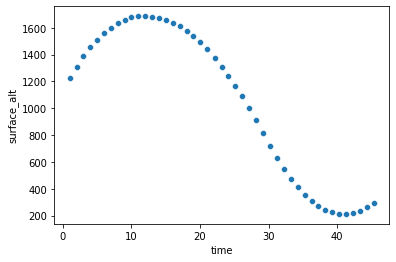

In [23]:
sns.scatterplot(data= flight, x = 'time', y = 'surface_alt')

In [41]:
flight.iloc[8]

time                                                      9.0447
mass                                                     8517.41
velocity                                                -33.0379
surface_alt                                              309.317
mean_alt                                                 381.689
throttle                                                       0
status                                                 Free Fall
drag           (1363.1727810205293, -1.0003057561651623, 16.2...
CoM                                             (0.0, 0.0, -0.0)
Name: 8, dtype: object

In [24]:
flight['time'].max() - flight['time'].min()

44.32730007171631

In [43]:
decent_list = []
for second in decent_profile.keys():
    decent_list.append((second, decent_profile[second]['height'], decent_profile[second]['velocity']))
decent = pd.DataFrame(decent_list, columns =['time', 'height', 'velocity'])
decent.tail()

,time,height,velocity
4,4,315.419632,-49.138
5,5,261.376230,-58.948
6,6,197.522828,-68.758
7,7,123.859426,-78.568
8,8,40.386024,-88.378


In [29]:
decent['adjusted_time'] = decent['time'].apply(lambda x: x + 10)

In [32]:
decent.head()

,time,height,velocity,adjusted_time
0,0,1753.797579,-10.095,10
1,1,1738.797167,-19.905,11
2,2,1713.986755,-29.715,12
3,3,1679.366343,-39.525,13
4,4,1634.935931,-49.335,14


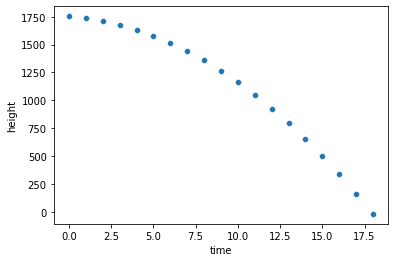

In [34]:
df_profile = pd.DataFrame(decent, columns =['time', 'height', 'velocity'])
sns.scatterplot(data= df_profile, x = 'time', y = 'height')